# Score variants of concerns (VOCs) using escape maps

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


In [33]:
import pandas as pd
import torch
from escape_map_torch import EscapeMapTorch
from escape_map import EscapeMap, load_escape_map_from_csv, score_seq_batch
 

# Example usage:
tag="2021-07-01"
model = load_escape_map_from_csv("../params_by_period_0.03_m1_m8_m7/param_period_"+tag+".csv")
model.raw_beta=-20
FASTA = "../seq_data/ns_mutated_spike.fasta"  # headers: >{date}|{region}|{pango}


   period_key      pango date_parsed     score
0     2019-H2          B  2019-12-23 -7.637491
1     2020-H1        B.1  2020-01-28 -7.637491
2     2020-H2      B.1.1  2020-07-01 -7.637491
3     2021-H1    B.1.1.7  2021-01-01 -7.724305
4     2021-H2  B.1.617.2  2021-07-01 -4.246644
5     2022-H1       BA.2  2022-01-02 -7.331172
6     2022-H2     BA.5.2  2022-07-01 -5.504550
7     2023-H1    XBB.1.5  2023-01-03 -5.009343
8     2023-H2   EG.5.1.1  2023-07-01 -5.051325
9     2024-H1       JN.1  2024-01-01 -5.497027
10    2024-H2   KP.3.1.1  2024-07-01 -5.895512
11    2025-H1   LP.8.1.1  2025-01-01 -5.303667
12    2025-H2        XFG  2025-07-01 -5.732160


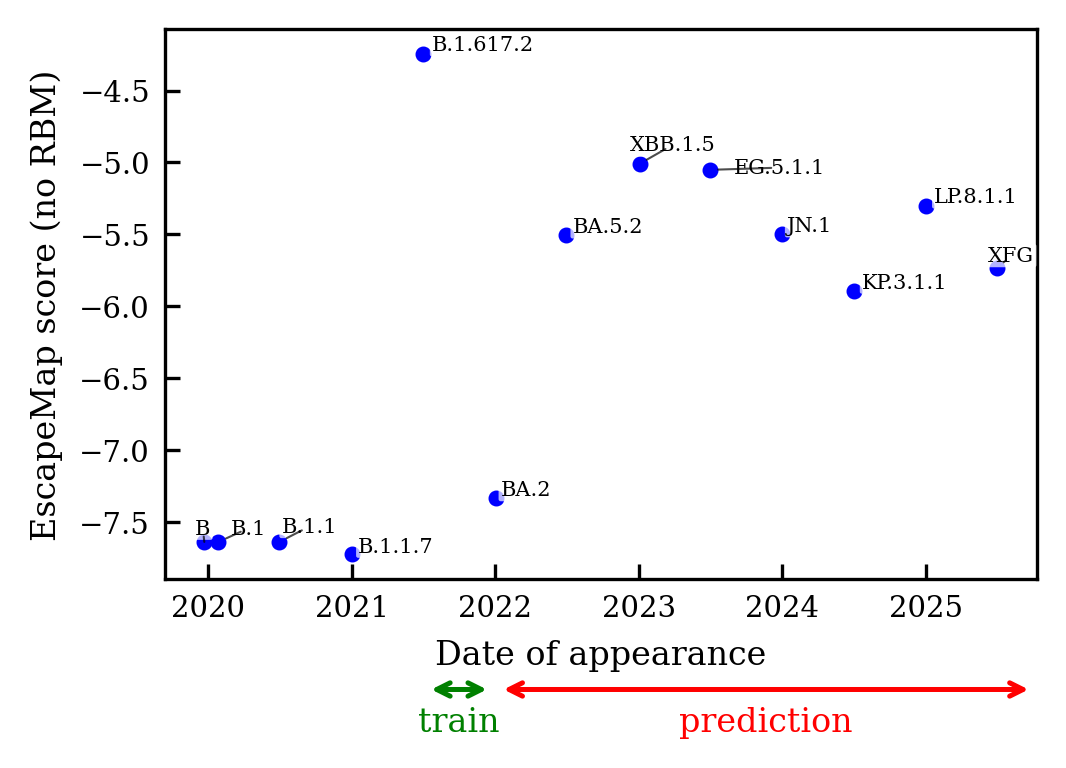

In [35]:
import re
import numpy as np
import torch
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

# --- helpers ---
def read_fasta_headers_and_seqs(path):
    headers, seqs = [], []
    with open(path, "r") as f:
        cur = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if cur:
                    seqs.append("".join(cur)); cur = []
                headers.append(line[1:])
            else:
                cur.append(line)
        if cur:
            seqs.append("".join(cur))
    return headers, seqs

def parse_header(h):
    # >date|region|pango
    parts = h.split("|")
    date  = parts[0] if len(parts) > 0 else ""
    pango = parts[2] if len(parts) > 2 else ""
    return date, pango

# --- 1) read fasta and numeric sequences in the same order ---
headers, seqs_str = read_fasta_headers_and_seqs(FASTA)
VOCS_NUM = Proteins_utils.load_FASTA(FASTA, drop_duplicates=False)  # numeric encoding
assert len(headers) == len(seqs_str) == len(VOCS_NUM), "FASTA order mismatch"

df = pd.DataFrame({
    "idx": np.arange(len(headers)),
    "header": headers,
    "seq_str": seqs_str
})
df[["date", "pango"]] = df["header"].apply(lambda h: pd.Series(parse_header(h)))
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date_parsed"]).reset_index(drop=True)

# --- half-year bins ---
df["year"] = df["date_parsed"].dt.year
df["half"] = np.where(df["date_parsed"].dt.month <= 6, 1, 2)
df["period_key"] = df["year"].astype(str) + "-H" + df["half"].astype(str)
# ensure chronological processing of bins
period_order = (
    df.groupby("period_key", as_index=False)["date_parsed"]
      .min().sort_values("date_parsed")["period_key"].tolist()
)

# --- per-bin representative:
# pick dominant pango if new; else second dominant. Ties by earliest first-seen date.
reps = []
seen_pangos = set()
for key in period_order:
    g = df[df["period_key"] == key]
    if g.empty:
        continue

    # rank pangos by count desc, tie-break by earliest date
    counts = g.groupby("pango").size().rename("cnt")
    first_seen = g.groupby("pango")["date_parsed"].min().rename("first_seen")
    rank = (pd.concat([counts, first_seen], axis=1)
              .sort_values(["cnt", "first_seen"], ascending=[False, True])
              .reset_index())

    # choose pango: dominant if not seen before, else second dominant if available
    if rank.empty:
        continue
    if rank.loc[0, "pango"] not in seen_pangos:
        chosen_pango = rank.loc[0, "pango"]
    elif len(rank) >= 2 and rank.loc[1, "pango"] not in seen_pangos:
        chosen_pango = rank.loc[1, "pango"]
    elif len(rank) >= 3 and rank.loc[2, "pango"] not in seen_pangos:
        chosen_pango = rank.loc[2, "pango"]
    else:
        continue
        

    # within chosen pango pick representative sequence:
    # most frequent sequence, tie-break earliest date
    g_choice = g[g["pango"] == chosen_pango].copy()
    seq_counts = g_choice["seq_str"].value_counts()
    top_seq = seq_counts.idxmax()
    cand = g_choice[g_choice["seq_str"] == top_seq].sort_values("date_parsed", ascending=True).iloc[0]

    reps.append({
        "period_key": key,
        "pango": cand["pango"],
        "date_parsed": cand["date_parsed"],
        "idx": int(cand["idx"]),
        "header": cand["header"]
    })
    # mark as seen for next bins
    seen_pangos.add(chosen_pango)

df_dom = pd.DataFrame(reps).sort_values("date_parsed").reset_index(drop=True)

# --- score only the selected representatives ---
seqs_batch = VOCS_NUM[df_dom["idx"].to_numpy()]
df_dom["score"] = score_seq_batch(model, seqs_batch)

print(df_dom[["period_key", "pango", "date_parsed", "score"]])

# --- plot: one red point per half-year (selected representative) ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.0,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))
ax.scatter(df_dom["date_parsed"], df_dom["score"], s=8, c="blue")
import numpy as np
import matplotlib.dates as mdates

# --- after your scatter(...) call ---

labels = []
try:
    from adjustText import adjust_text

    # draw texts first
    for _, r in df_dom.iterrows():
        labels.append(
            ax.text(r["date_parsed"], r["score"], r["pango"],
                    fontsize=5, zorder=3,
                    bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.7))
        )

    # nudge to avoid overlaps
    adjust_text(
        labels, ax=ax,
        only_move={'points':'y', 'text':'xy'},
        force_text=0.5, force_points=0.3,
        expand_points=(1.2, 1.4), expand_text=(1.1, 1.2),
        arrowprops=dict(arrowstyle='-', lw=0.5, alpha=0.7)
    )

except Exception:
    # --- fallback: deterministic small jitters in points ---
    # order by date to spread offsets
    tmp = df_dom.sort_values("date_parsed").reset_index(drop=True)
    offsets = ((np.arange(len(tmp)) % 7) - 3) * 2  # [-6,-4,-2,0,2,4,6] pt

    for i, r in tmp.iterrows():
        ax.annotate(r["pango"], (r["date_parsed"], r["score"]),
                    xytext=(0, offsets[i]), textcoords="offset points",
                    fontsize=7, zorder=3,
                    bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.7))
        
# --- end after scatter(...) ---
import matplotlib.dates as mdates
import pandas as pd

# ensure room for below-axis annotations
plt.subplots_adjust(bottom=0.25)

# bounds
x0_num, x1_num = ax.get_xlim()
x0 = mdates.num2date(x0_num)
x1 = mdates.num2date(x1_num)
train_date = pd.Timestamp(tag)
mid = train_date+pd.DateOffset(months=6)  # extend train arrow 6 months right
x0 = train_date  # extend train arrow 6 months left

# y position below axis in axes-fraction coords
y = -0.2
xf = ax.get_xaxis_transform()  # x in data coords, y in axes fraction

# green train arrow
ax.annotate("", xy=(mid, y), xytext=(x0, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="green"))
cx_train = mdates.num2date((mdates.date2num(x0) + mdates.date2num(mid)) / 2)
ax.text(cx_train, y - 0.03, "train", color="green", ha="center", va="top",
        transform=xf)

# red prediction arrow
ax.annotate("", xy=(x1, y), xytext=(mid, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="red"))
cx_pred = mdates.num2date((mdates.date2num(mid) + mdates.date2num(x1)) / 2)
ax.text(cx_pred, y - 0.03, "prediction", color="red", ha="center", va="top",
        transform=xf)


ax.set_xlabel("Date of appearance")
ax.set_ylabel("EscapeMap score (no RBM)")
ax.tick_params(direction="in", which="both", top=False, right=False)
fig.tight_layout(pad=0.5)
plt.show()

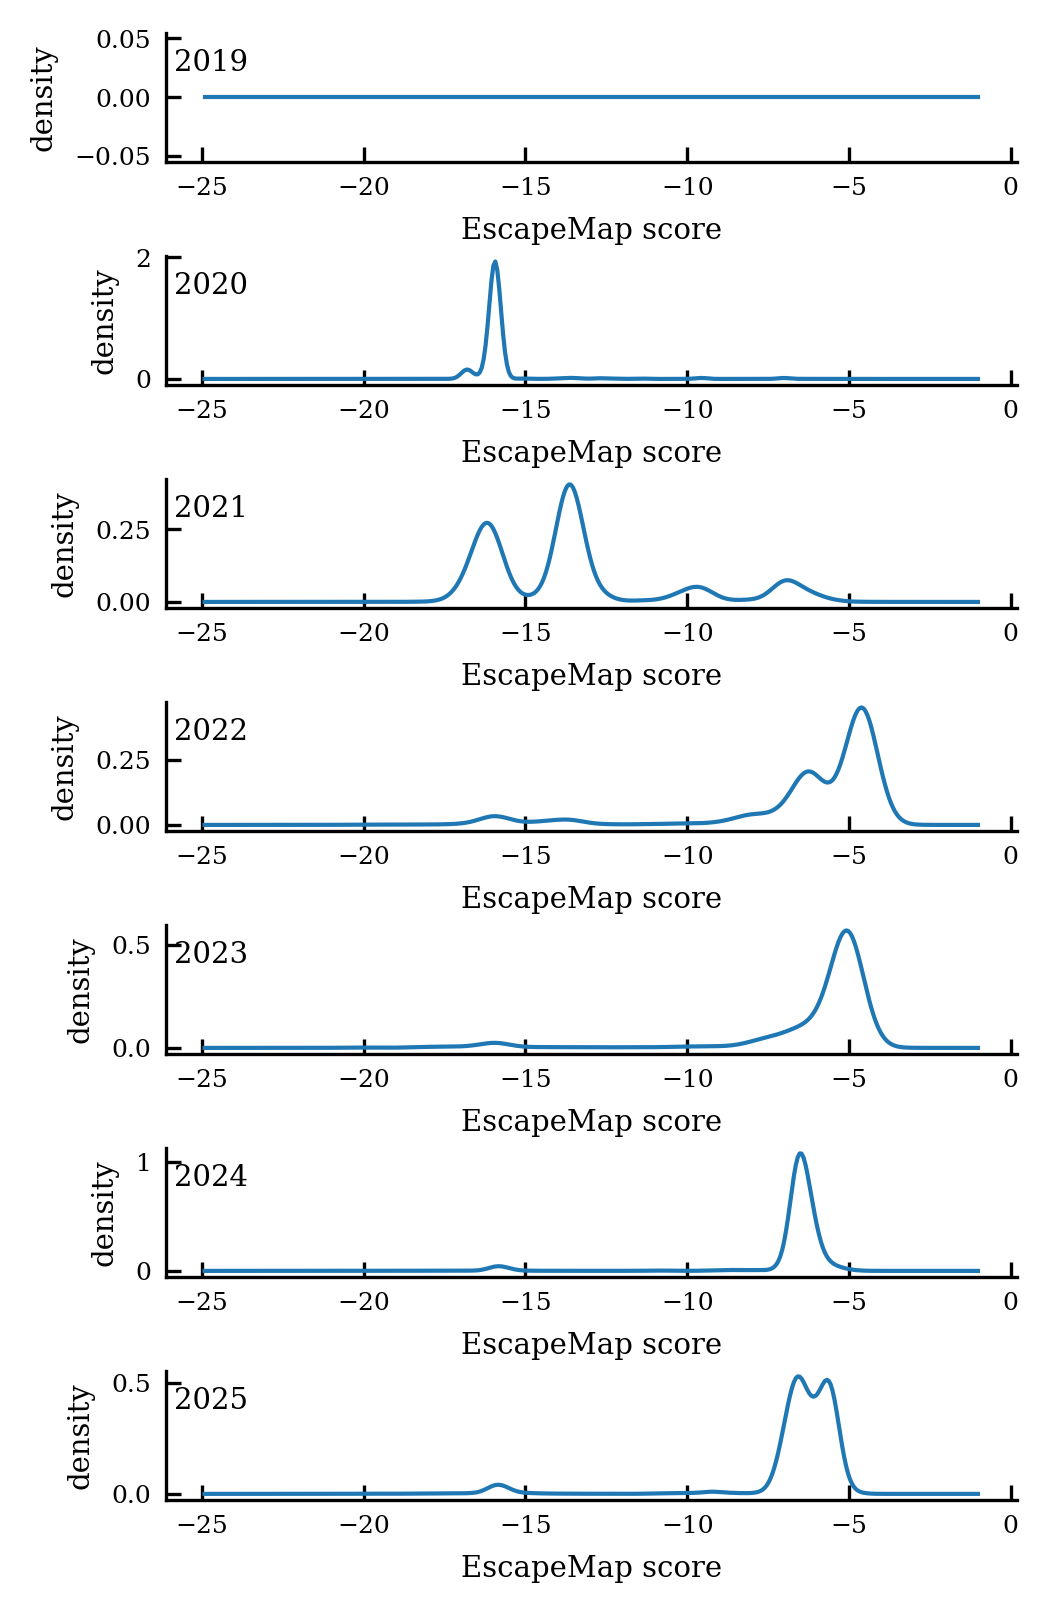

In [30]:
scores_all = score_seq_batch(model, VOCS_NUM)
df["score"] = scores_all[df["idx"].to_numpy()]

# ---------- density per period ----------
# common x-grid for comparability
xmin = df["score"].min()
xmax = df["score"].max()
xrng = xmax - xmin
xgrid = np.linspace(xmin - 0.05 * xrng, xmax + 0.05 * xrng, 400)

def kde_density(x, grid):
    # Gaussian KDE with simple plug-in bandwidth; fallback to histogram if too few points
    x = np.asarray(x, dtype=float)
    if x.size >= 3:
        # Scott's rule
        std = np.std(x, ddof=1) if x.size > 1 else 1.0
        bw = std * x.size ** (-1 / 5)
        bw = max(bw, 1e-6)
        diffs = grid[:, None] - x[None, :]
        kern = np.exp(-0.5 * (diffs / bw) ** 2) / (np.sqrt(2 * np.pi) * bw)
        dens = kern.mean(axis=1)
        return dens
    else:
        # normalized histogram kernel
        hist, edges = np.histogram(x, bins=min(5, max(1, x.size)), range=(xrng and (xmin, xmax) or (0, 1)), density=True)
        centers = 0.5 * (edges[1:] + edges[:-1])
        return np.interp(grid, centers, hist, left=0, right=0)

# ---------- PRL-style stacked plots ----------
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.0,
    "font.size": 7, "axes.labelsize": 7, "xtick.labelsize": 6, "ytick.labelsize": 6,
    "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})
# --- yearly bins instead of half-year ---
df["year"] = df["date_parsed"].dt.year
df["period_key"] = df["year"].astype(int)

period_order = (
    df.groupby("period_key", as_index=False)["date_parsed"]
      .min().sort_values("date_parsed")["period_key"].tolist()
)

# --- PRL-style stacked plots (annual) ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.0,
    "font.size": 7, "axes.labelsize": 7, "xtick.labelsize": 6, "ytick.labelsize": 6,
    "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

n = len(period_order)
fig_h = max(0.75 * n, 1.2)
# Remove sharex=True to ensure each subplot has its own x-axis ticks
fig, axes = plt.subplots(n, 1, figsize=(3.375, fig_h), sharex=False)
if n == 1:
    axes = [axes]

for ax, key in zip(axes, period_order):
    # if period aftr 2021-12 skip
    s = df.loc[df["period_key"] == key, "score"].to_numpy()
    d = kde_density(s, xgrid)
    ax.plot(xgrid, d, lw=1.0)
    ax.set_ylabel("density")
    ax.text(0.01, 0.88, str(key), transform=ax.transAxes, ha="left", va="top")
    ax.tick_params(direction="in", top=False, right=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # Set x-axis label and ticks for each individual subplot
    ax.set_xlabel("EscapeMap score")

fig.tight_layout(pad=0.4, h_pad=0.15)
plt.show()

In [31]:
df

,idx,header,seq_str,date,pango,date_parsed,year,half,period_key,score
0,0,2021-03-15|South America|P.3,SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,2021-03-15,P.3,2021-03-15,2021,1,2021,-9.806220
1,1,2020-06-04|South America|B.1,SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,2020-06-04,B.1,2020-06-04,2020,1,2020,-15.939193
2,2,2020-06-04|South America|B.1,SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,2020-06-04,B.1,2020-06-04,2020,1,2020,-15.939193
3,3,2020-06-04|South America|B.1,SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,2020-06-04,B.1,2020-06-04,2020,1,2020,-15.939193
4,4,2020-06-04|South America|B.1,SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTN...,2020-06-04,B.1,2020-06-04,2020,1,2020,-15.939193
...,...,...,...,...,...,...,...,...,...,...
98048,99768,2023-03-20|Europe|EG.1.7,SVYAWNRKRISNCVADYSVIYNFAPFFAFKCYGVSPTKLNDLCFTN...,2023-03-20,EG.1.7,2023-03-20,2023,1,2023,-6.473135
98049,99769,2022-09-11|Europe|BF.1,SVYAWNRKRISNCVADYSVLYNFAPFFAFKCYGVSPTKLNDLCFTN...,2022-09-11,BF.1,2022-09-11,2022,2,2022,-4.621995
98050,99770,2023-03-30|Europe|XBB.1.5,SVYAWNRKRISNCVADYSVIYNFAPFFAFKCYGVSPTKLNDLCFTN...,2023-03-30,XBB.1.5,2023-03-30,2023,1,2023,-4.970128
98051,99771,2023-03-06|Europe|BQ.1.1,SVYAWNRKRISNCVADYSVLYNFAPFFAFKCYGVSPTKLNDLCFTN...,2023-03-06,BQ.1.1,2023-03-06,2023,1,2023,-4.819365


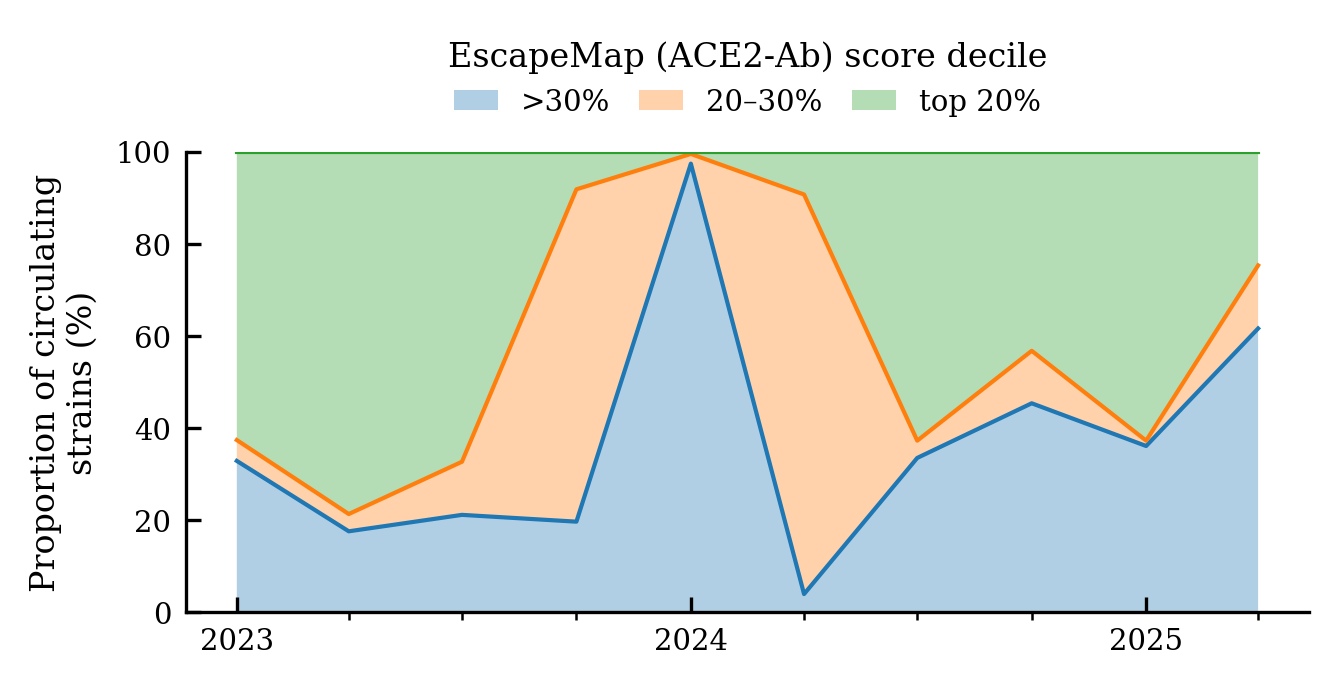

()

In [37]:
# after building df (idx, header, seq_str, date_parsed) and gseq (first_seen, idx_first)
# 1) weight = number of appearances of each sequence in the FASTA
model = load_escape_map_from_csv("../params_by_period_0.03_m1_m8_m7/param_period_2022-10-01.csv")
model.raw_beta=-10

# ---------- 3-month bins ----------
def quarter_start(ts: pd.Timestamp) -> pd.Timestamp:
    m = ((ts.month - 1) // 3) * 3 + 1
    return pd.Timestamp(ts.year, m, 1)

# first appearance per unique sequence
gseq = df.groupby("seq_str").agg(first_seen=("date_parsed", "min"),
                                 idx_first=("idx", "min")).reset_index()
gseq["first_period_start"] = gseq["first_seen"].apply(quarter_start)



seqs_unique = VOCS_NUM[gseq["idx_first"].to_numpy()]
gseq["score"] = score_seq_batch(model, seqs_unique)

# ---------- global thresholds ----------
q95 = np.nanpercentile(gseq["score"], 80)
q80 = np.nanpercentile(gseq["score"], 70)

def cat_from_score(s):
    if s >= q95: return "top5"
    if s >= q80: return "p5to20"
    return "above20"

gseq["cat"] = gseq["score"].apply(cat_from_score)
START_YEAR=2023
END_YEAR=2025
# --- weighting, scoring, categories (fixed q95=95) ---
w_counts = df.groupby("seq_str").size().rename("w").reset_index()
gseq = gseq.merge(w_counts, on="seq_str", how="left")
gseq["w"] = gseq["w"].fillna(1).astype(int)

def quarter_start(ts: pd.Timestamp) -> pd.Timestamp:
    m = ((ts.month - 1) // 3) * 3 + 1
    return pd.Timestamp(ts.year, m, 1)

gseq["first_period_start"] = gseq["first_seen"].apply(quarter_start)

seqs_unique = VOCS_NUM[gseq["idx_first"].to_numpy()]
gseq["score"] = score_seq_batch(model, seqs_unique)



def cat_from_score(s):
    if s >= q95: return "top5"
    if s >= q80: return "p5to20"
    return "above20"

gseq["cat"] = gseq["score"].apply(cat_from_score)

START_YEAR, END_YEAR = 2023, 2025
quarters = pd.period_range(f"{START_YEAR}-01", f"{END_YEAR}-06", freq="Q")
periods = [pd.Timestamp(p.start_time.year, p.start_time.month, 1) for p in quarters]

rows = []
for p in periods:
    gp = gseq[gseq["first_period_start"] == p]
    totw = gp["w"].sum()
    if totw == 0:
        rows.append({"period": p, "top5": 0.0, "p5to20": 0.0, "above20": 0.0, "count": 0})
        continue
    rows.append({
        "period": p,
        "top5":   100.0 * gp.loc[gp["cat"] == "top5",   "w"].sum() / totw,
        "p5to20": 100.0 * gp.loc[gp["cat"] == "p5to20", "w"].sum() / totw,
        "above20":100.0 * gp.loc[gp["cat"] == "above20","w"].sum() / totw,
        "count": int(totw),
    })

df_prop = pd.DataFrame(rows).sort_values("period").reset_index(drop=True)

# --- plot: lines + fill-between; sparser x-ticks to avoid overlap ---
import matplotlib.dates as mdates
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.0,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

x = df_prop["period"].to_numpy()
y_low  = df_prop["above20"].to_numpy()
y_mid  = df_prop["p5to20"].to_numpy()
y_top5 = df_prop["top5"].to_numpy()

cum1 = y_low
cum2 = y_low + y_mid
cum3 = y_low + y_mid + y_top5  # should be 100

fig, ax = plt.subplots(figsize=(4.375, 2.2))

# lines
ax.plot(x, cum1, lw=1.0)
ax.plot(x, cum2, lw=1.0)
ax.plot(x, cum3, lw=1.0)

# fills (no bars)
ax.fill_between(x, 0,    cum1, alpha=0.35, label=">30%")
ax.fill_between(x, cum1, cum2, alpha=0.35, label="20–30%")
ax.fill_between(x, cum2, cum3, alpha=0.35, label="top 20%")

# axes
ax.set_ylim(0, 100)
ax.set_ylabel("Proportion of circulating\nstrains (%)")
# ax.set_xlabel("Time")

# sparse yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4, 7, 10]))

ax.tick_params(direction="in", top=False, right=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="lower center",
          bbox_to_anchor=(0.5, 1.02),
          ncol=3, frameon=False, handlelength=1.5, columnspacing=1.0, title='EscapeMap (ACE2-Ab) score decile')

fig.tight_layout(pad=0.5)
plt.show()
()